# **Introducción**

Este cuaderno muestra una **predicción a largo plazo (hasta 10 días)** de la variable oceánica `thetao` utilizando el modelo **Aurora**. En particular:

1. Se define una ventana de muestra con 2 días de información inicial (historia) y 10 días de pronóstico (*rollout con `steps=10`*).
2. Para cada batch, se obtiene una **predicción diaria** durante 10 pasos consecutivos.
3. Se evalúa la calidad de dichas predicciones calculando métricas como el **RMSE** (de manera global y por día), así como la **diferencia espacial** entre la predicción y la realidad (target) en forma de mapas.

---

# **Proceso de Inferencia a 10 Días**

A diferencia del clásico *rollout* de un día, se ha modificado el código para:

- **Realizar** `rollout(model, batch, steps=10)`, generando una lista de 10 predicciones (1 día, 2 días, …, hasta 10 días en el futuro).
- Almacenar cada predicción diaria (en `predictions_per_day`) y el target correspondiente (en `targets_for_comparison`).
- Calcular métricas como el **RMSE** global por cada día de horizonte.

Los resultados se presentan en:

1. **Tabla/Lista** con el RMSE diario (1 a 10 días).  
2. **Gráficos** que muestran cómo el RMSE crece a medida que el horizonte de predicción se alarga.
3. **Visualizaciones espaciales** de la **diferencia** (Predicción - Target) para un ejemplo de la data de prueba, a lo largo de los 10 días.

---

In [1]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from tqdm import tqdm
from typing import List, Tuple

from aurora import Aurora, Batch, Metadata, normalisation, rollout



#dataset = xr.open_dataset("/Users/victormedina/Desktop/cmems_preprocessed_oceanographic_data.nc", engine="netcdf4")
#dataset = xr.open_dataset("D://Aaron///cmems_mod_glo_phy_my_0.083deg_P1D-m_v1_little.nc")
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc").isel(time=slice(0,30))
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m_v1.nc", engine="netcdf4") #dataset de 3 dias
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m.nc", engine="netcdf4") #dataset de 3 años que solo ejecuta en pc grande
dataset



c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.Dataset> Size: 32GB
Dimensions:    (depth: 49, latitude: 180, longitude: 180, time: 2558)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 20kB 2014-01-01 2014-01-02 ... 2021-01-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 32GB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#importar variable 
lsm = xr.open_dataset("D://Aaron/datos_mascara.nc")

In [4]:

variables = ['thetao']  # Solo 'thetao'
dataset = dataset[variables]

# Cargar el dataset solo con la variable que necesitas
variables = ['thetao']  # Selecciona solo 'thetao'


# Filtrar por la profundidad (limitando el número de niveles de profundidad)
dataset = dataset.isel(depth=slice(0, 10))  # Limitar a los primeros 10 niveles de profundidad
ocean_levels = dataset['depth'].values

# Ajustar las longitudes para que coincidan en rango (de -180 a 180) y latitudes para interpolación
lsm_copy = lsm.copy()
lsm_copy = lsm_copy.assign_coords(longitude=(((lsm_copy.longitude + 180) % 360) - 180))

# Interpolar la variable lsm para que coincida con la resolución del dataset
lsm_interp = lsm_copy.interp(latitude=dataset.latitude, longitude=dataset.longitude, method="nearest")

# Asignar la variable lsm al dataset sin añadir coordenadas innecesarias
lsm_interp_clean = lsm_interp.fillna(0)  # Reemplazar los NaNs por ceros
dataset['lsm'] = lsm_interp_clean['lsm']

# Eliminar las coordenadas innecesarias si se añadieron automáticamente
coordinates_to_drop = ['number', 'step', 'surface', 'valid_time']
for coord in coordinates_to_drop:
    if coord in dataset.coords:
        dataset = dataset.drop_vars(coord)

# Verificar y ajustar las latitudes para asegurar que están en el orden correcto y dentro del rango adecuado
def check_latitudes(dataset: xr.Dataset) -> xr.Dataset:
    latitude = dataset['latitude'].values
    if not (np.all(latitude <= 90) and np.all(latitude >= -90)):
        raise ValueError("Algunos valores de latitud están fuera del rango [-90, 90]. Por favor, corrígelos.")
    if not np.all(np.diff(latitude) < 0):
        dataset = dataset.sortby('latitude', ascending=False)
    return dataset

# Ajustar las longitudes para que estén dentro del rango [0,360]
def check_longitudes(dataset: xr.Dataset) -> xr.Dataset:
    dataset = dataset.assign_coords(longitude=((dataset.longitude + 360) % 360))
    return dataset

# Aplicar funciones de verificación al dataset
dataset = check_latitudes(dataset)
dataset = check_longitudes(dataset)

# Convertir latitudes y longitudes a tensores de Torch para su posterior uso
latitude = torch.from_numpy(dataset['latitude'].values).float()
longitude = torch.from_numpy(dataset['longitude'].values).float()

# Revisar si hay valores NaN restantes después de la interpolación y eliminarlos si es necesario
dataset = dataset.dropna(dim="latitude", how="all").dropna(dim="longitude", how="all")

# Rellenar los valores NaN con la media de la variable
def fill_nan_with_mean(var: xr.DataArray) -> xr.DataArray:
    if var.isnull().any():
        return var.fillna(var.mean())
    else:
        return var

for var in variables:
    dataset[var] = fill_nan_with_mean(dataset[var])



In [5]:
# Definir funciones para cargar datos
def load_ocean_surface(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables de superficie para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable de superficie.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {}
        if 'depth' in sample_set[v].dims:
            sel_dict['depth'] = 0  # Seleccionar nivel superficial
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,12)).values  # (lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (lat, lon)


        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch (nueva dimensión 0)
    data_batch = torch.stack(data_list, dim=0)    # (batch_size, time, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, 1, lat, lon)

    return data_batch, target_batch




def load_ocean_atmos(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables atmosféricas para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable atmosférica.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {'depth': slice(0, 10)}  # Seleccionar los primeros N niveles de profundidad
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, depth, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, depth, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,12)).values  # (depth, lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (depth, lat, lon)
        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch
    data_batch = torch.stack(data_list, dim=0)  # (batch_size, time, depth, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, depth, lat, lon)

    return data_batch, target_batch



def load_static_var(v: str, sample_sets: list) -> torch.Tensor:
    """
    Carga una variable estática del dataset.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        torch.Tensor: Tensor con los datos de la variable estática (lat, lon).
    """
    # Since static variables are the same across the batch, we can take from the first sample
    sample_set = sample_sets[0]
    data_var = sample_set[v]
    dims_to_drop = [dim for dim in data_var.dims if dim not in ('latitude', 'longitude')]
    data_var = data_var.isel({dim: 0 for dim in dims_to_drop})
    data = data_var.values  # Should be (lat, lon)
    data_tensor = torch.from_numpy(data).float()

    return data_tensor  # Shape: (lat, lon)



In [6]:

surf_vars: tuple[str, ...] = ('thetao',)
static_vars: tuple[str, ...] = ('lsm',)
atmos_vars: tuple[str, ...] = ('thetao',)

# Crear el modelo Aurora y moverlo al dispositivo
model = Aurora(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, use_lora=False,autocast=True).to(device)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
print("Modelo Aurora cargado y ajustado exitosamente.") 


Modelo Aurora cargado y ajustado exitosamente.


# Dividir el conjunto de Datos

In [7]:
#de cuando a cuando es el dataset
print(f"Rango de tiempo del conjunto total de datos: {dataset['time'].values[0]} a {dataset['time'].values[-1]}")

#Definir las estaciones del año según el mes (ya es un número entero)
# Definir las estaciones del año según el mes
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

# Aplicar la función get_season a la columna de meses del dataset usando dask
dataset['season'] = xr.apply_ufunc(
    np.vectorize(get_season),
    dataset['time'].dt.month,  # Usamos el mes directamente
    vectorize=True,
    dask="parallelized",  # Habilitar dask para procesamiento en paralelo
    output_dtypes=[str]  # Definir el tipo de salida
)
#Función para dividir el dataset respetando las estaciones y evitando solapamientos
def split_by_time(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Divide el dataset en entrenamiento, validación y prueba asegurando que todas las estaciones estén
    representadas en cada conjunto y no haya solapamientos temporales.

    Args:
        dataset_años (xr.Dataset): El dataset con la dimensión 'time'.
        train_ratio (float): Proporción de datos para el conjunto de entrenamiento.
        val_ratio (float): Proporción de datos para el conjunto de validación.
        test_ratio (float): Proporción de datos para el conjunto de prueba.

    Returns:
        train_dataset_años (xr.Dataset): Conjunto de entrenamiento con todas las estaciones.
        val_dataset_años (xr.Dataset): Conjunto de validación con todas las estaciones.
        test_dataset_años (xr.Dataset): Conjunto de prueba con todas las estaciones.
    """
    # Total de puntos temporales en el dataset
    num_times = len(dataset['time'])
    
    # Calcular los índices para dividir los datos
    train_index = int(train_ratio * num_times)
    val_index = int(val_ratio * num_times)
    
    # Crear los conjuntos secuencialmente por tiempo (sin solapamiento)
    train_dataset = dataset.isel(time=slice(0, train_index))
    val_dataset = dataset.isel(time=slice(train_index, train_index + val_index))
    test_dataset = dataset.isel(time=slice(train_index + val_index, num_times))

    # Ahora aseguramos que cada conjunto tenga ejemplos de todas las estaciones
    def ensure_all_seasons(dataset):
        # Verificar qué estaciones están presentes en este dataset
        seasons_present = np.unique(dataset['season'].values)
        missing_seasons = set(['winter', 'spring', 'summer', 'fall']) - set(seasons_present)
        
        if missing_seasons:
            raise ValueError(f"El dataset no tiene datos de las estaciones: {missing_seasons}")
        return dataset
    
    train_dataset = ensure_all_seasons(train_dataset)
    val_dataset = ensure_all_seasons(val_dataset)
    test_dataset = ensure_all_seasons(test_dataset)

    return train_dataset, val_dataset, test_dataset

# Llamar a la función para dividir el dataset secuencialmente y asegurar que contenga todas las estaciones
train_dataset, val_dataset, test_dataset = split_by_time(dataset)
#Imprimir tamaños y rangos de los conjuntos de datos resultantes
print(f"Conjunto de entrenamiento: {len(train_dataset['time'])} instancias temporales")
print(f"Conjunto de validación: {len(val_dataset['time'])} instancias temporales")
print(f"Conjunto de prueba: {len(test_dataset['time'])} instancias temporales")

print(f"Rango de tiempo del conjunto de entrenamiento: {train_dataset['time'].values[0]} a {train_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de validación: {val_dataset['time'].values[0]} a {val_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de prueba: {test_dataset['time'].values[0]} a {test_dataset['time'].values[-1]}")

Rango de tiempo del conjunto total de datos: 2014-01-01T00:00:00.000000000 a 2021-01-01T00:00:00.000000000
Conjunto de entrenamiento: 1790 instancias temporales
Conjunto de validación: 383 instancias temporales
Conjunto de prueba: 385 instancias temporales
Rango de tiempo del conjunto de entrenamiento: 2014-01-01T00:00:00.000000000 a 2018-11-25T00:00:00.000000000
Rango de tiempo del conjunto de validación: 2018-11-26T00:00:00.000000000 a 2019-12-13T00:00:00.000000000
Rango de tiempo del conjunto de prueba: 2019-12-14T00:00:00.000000000 a 2021-01-01T00:00:00.000000000


In [8]:
train_ocean_levels = train_dataset['depth'].values

# Normalización para thetao en los niveles oceánicos
for level in train_ocean_levels:
    level_str = f"{level}"
    var = "thetao"
    data = train_dataset[var].sel(depth=level).values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[f"{var}_{level_str}"] = mean
    normalisation.scales[f"{var}_{level_str}"] = std

# Normalización para thetao en la superficie
surface_vars = ["thetao"]
for var in surface_vars:
    if 'depth' in train_dataset[var].dims:
        data = train_dataset[var].isel(depth=0).values
    else:
        data = train_dataset[var].values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[var] = mean
    normalisation.scales[var] = std

print("Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.")



Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.


In [9]:
class BatchGenerator:
    def __init__(self, dataset: xr.Dataset, sample_size: int, batch_size: int, shuffle: bool = True, padding: bool = True):
        """
        Inicializa el BatchGenerator.

        Args:
            dataset (xr.Dataset): El conjunto de datos.
            sample_size (int): Tamaño de cada ventana deslizante.
            batch_size (int): Tamaño de cada batch.
            shuffle (bool): Si se deben barajar las muestras.
            padding (bool): Si se debe aplicar padding al último batch.
        """
        self.dataset = dataset
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding = padding
        self.samples = self.generate_sliding_windows()
        if self.shuffle:
            self.samples = self.shuffle_samples()

    def generate_sliding_windows(self):
        """
        Genera ventanas deslizantes sobre el eje temporal del dataset.

        Returns:
            list: Lista de muestras generadas mediante ventanas deslizantes.
        """
        window_size = self.sample_size
        windows = [slice(i, i + window_size) for i in range(0, len(self.dataset.time) - window_size + 1)]
        samples = [self.dataset.isel(time=w) for w in windows]
        return samples

    def shuffle_samples(self):
        """
        Baraja las muestras generadas.

        Returns:
            list: Lista de muestras barajadas.
        """
        samples_copy = self.samples.copy()
        np.random.shuffle(samples_copy)
        return samples_copy

    def load_ocean_batch(self, sample_sets):
        """
    Carga un batch de datos a partir de un conjunto de muestras.

    Args:
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[Batch, Batch]: Batch de datos y batch de targets.
        """
        is_padding = any(sample.attrs.get('is_padding', False) for sample in sample_sets)

    # Llamar a las funciones de carga modificadas
        surf_data, surf_target = load_ocean_surface("thetao", sample_sets)
        atmos_data, atmos_target = load_ocean_atmos("thetao", sample_sets)
        static_data = load_static_var("lsm", sample_sets).to(device)

        times = [
            sample_set['time'].values[-1].astype('datetime64[s]').astype(datetime)
            for sample_set in sample_sets
        ]
    # Crear instancia de Batch para el batch completo
        batch = Batch(
            surf_vars={
                "thetao": surf_data,
            },
            static_vars={
                "lsm": static_data,
            },
            atmos_vars={
                "thetao": atmos_data,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch.metadata.is_padding = is_padding

        batch_target = Batch(
            surf_vars={
                "thetao": surf_target,
            },
            static_vars={
             "lsm": static_data,  # Asumimos que los static_vars son iguales para data y target
            },
            atmos_vars={
                "thetao": atmos_target,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch_target.metadata.is_padding = is_padding

        return batch, batch_target


    def __iter__(self):
        """
        Iterador que genera batches de datos.

        Yields:
            Tuple[list, list]: Batch de datos y batch de targets.
        """
        # Dividimos las muestras en batches
        for i in range(0, len(self.samples), self.batch_size):
            batch_samples = self.samples[i:i + self.batch_size]

            # Aplicamos padding si es necesario
            if len(batch_samples) < self.batch_size and self.padding:
                num_padding = self.batch_size - len(batch_samples)
                for _ in range(num_padding):
                    sample = self.samples[i % len(self.samples)]
                    sample = sample.copy()
                    sample.attrs['is_padding'] = True
                    batch_samples.append(sample)

            batch, batch_target = self.load_ocean_batch(batch_samples)
            yield batch, batch_target


In [10]:
import numpy as np

class Metricas:
    def __init__(self, latitudes):
        """ Inicializa la clase con latitudes y calcula las ponderaciones normalizadas. """
        self.latitudes = latitudes
        # Convertir latitudes a radianes
        lat_rad = np.deg2rad(self.latitudes)
        # Calcular los pesos y normalizar
        weights = np.cos(lat_rad)
        normalization_factor = np.mean(weights)
        self.weights = (weights / normalization_factor).reshape(1, -1, 1)
        
    
    def rmse(self, pred, target):
        """ Calcula el RMSE ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        
        # Calcular los errores cuadrados
        errors_squared = (pred - target) ** 2
        # Aplanar los arrays
        errors_squared_flat = errors_squared.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(errors_squared_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        errors_squared_flat = errors_squared_flat[mask]
        weights_flat = weights_flat[mask]
        
        
        # Calcular la media ponderada de los errores cuadrados
        mse_weighted = np.average(errors_squared_flat, weights=weights_flat)
        rmse_weighted = np.sqrt(mse_weighted)
        return rmse_weighted
    
    def bias(self, pred, target):
        """ Calcula el sesgo ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        # Calcular las diferencias
        differences = pred - target
        # Aplanar los arrays
        differences_flat = differences.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(differences_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        differences_flat = differences_flat[mask]
        weights_flat = weights_flat[mask]
        
        
        # Calcular el Bias ponderado
        bias_weighted = np.average(differences_flat, weights=weights_flat)
        return bias_weighted
    
    def acc(self, pred, target):
        """ Calcula el Coeficiente de Correlación de Anomalías (ACC) ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        # Aplanar los arrays
        pred_flat = pred.reshape(-1)
        target_flat = target.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(pred_flat) & ~np.isnan(target_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        pred_flat = pred_flat[mask]
        target_flat = target_flat[mask]
        weights_flat = weights_flat[mask]
        
        
        # Calcular las medias ponderadas
        pred_mean = np.average(pred_flat, weights=weights_flat)
        target_mean = np.average(target_flat, weights=weights_flat)
        
        
        # Calcular las anomalías
        pred_anomaly = pred_flat - pred_mean
        target_anomaly = target_flat - target_mean
        
        # Calcular covarianza y varianzas ponderadas
        covariance = np.average(pred_anomaly * target_anomaly, weights=weights_flat)
        pred_variance = np.average(pred_anomaly ** 2, weights=weights_flat)
        target_variance = np.average(target_anomaly ** 2, weights=weights_flat)
        
        
        # Calcular el ACC
        denominator = np.sqrt(pred_variance * target_variance)
        if denominator != 0:
            acc_weighted = covariance / denominator
        else:
            acc_weighted = np.nan
            print("El denominador es cero, ACC no está definido.")
        return acc_weighted


C:\Users\Victor\AppData\Local\Temp\ipykernel_3252\168258053.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

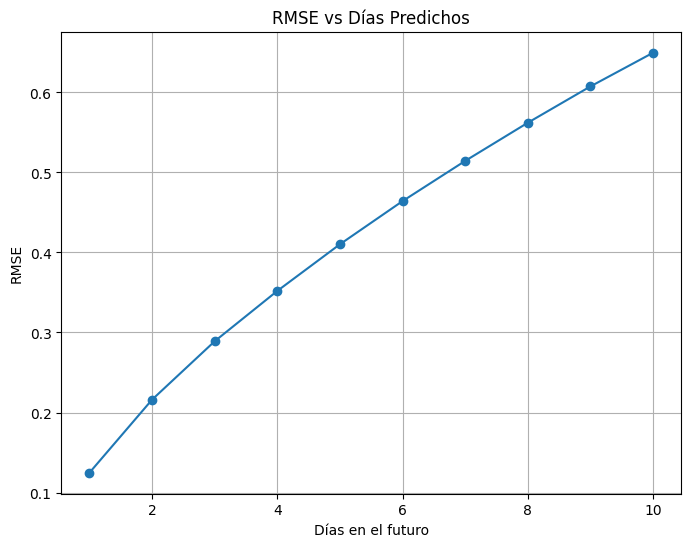

RMSE por día de predicción:
Día 1: RMSE = 0.12479066103696823
Día 2: RMSE = 0.21610771119594574
Día 3: RMSE = 0.28907376527786255
Día 4: RMSE = 0.35197770595550537
Día 5: RMSE = 0.41026440262794495
Día 6: RMSE = 0.46418848633766174
Día 7: RMSE = 0.514423131942749
Día 8: RMSE = 0.5621124505996704
Día 9: RMSE = 0.6074927449226379
Día 10: RMSE = 0.6495746970176697


In [ ]:


from aurora import Aurora, Batch, Metadata, normalisation, rollout

# Aquí asumo que tu dataset y las secciones anteriores se mantienen igual.
# He omitido las partes de carga y normalización del dataset que ya tienes en tu código original.
# Simplemente parto desde que ya tienes:
#   - dataset entrenado, normalizado
#   - train_dataset, val_dataset, test_dataset
#   - model Aurora inicializado y normalizado
#   - BatchGenerator, Metricas, etc.

# Asegúrate de que el código anterior a esta sección se mantiene sin cambios,
# excepto por el final donde hacemos la inferencia, que ahora se modificará.

# Crear generador de batches para el conjunto de prueba
batch_size = 3
test_generator = BatchGenerator(test_dataset, sample_size=12, batch_size=batch_size, shuffle=False, padding=False)
latitudes = dataset['latitude'].values
metricas = Metricas(latitudes)

# Cargar solo el modelo aurora_exp3_bs3.pth
model_path = 'C://Users//Victor//Desktop//modelo//aurora_exp3_bs3.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Ahora realizamos el rollout a 10 steps.
# Calcularemos el RMSE para cada horizonte de predicción (1 a 10 días).

# Almacenaremos las predicciones y los targets para cada día de predicción
# predictions_per_day[day] tendrá las predicciones del día "day" para todo el conjunto de test
# El índice day irá de 1 a 10 (para 10 steps).
predictions_per_day = [[] for _ in range(10)]
targets_for_comparison = []

timestamps = []

# Inferencia
for batch, batch_target in test_generator:
    if getattr(batch.metadata, 'is_padding', False):
        continue  # Ignorar los batches con padding


    target = batch_target.surf_vars['thetao'].to(device)  # target shape: (batch, 10, lat, lon)
    targets_for_comparison.append(target.cpu().numpy())
    timestamps.extend(batch.metadata.time)

    with torch.no_grad():
        # Hacemos rollout a 10 pasos
        outputs = [out.to(device) for out in rollout(model, batch, steps=10)]
        # 'outputs' será una lista de 10 Batch, cada uno con la predicción a +1 día, +2 días, ..., +10 días.
        
        # Guardamos las predicciones separadas por día
        # Cada elemento de outputs[i] es un Batch con la predicción del día i+1
        for i, out_day in enumerate(outputs):
            prediction_day = out_day.surf_vars['thetao'].cpu().numpy()  # shape: (batch, 1, lat, lon)
            # Ajustar shape para ser (batch, lat, lon) si es necesario:
            prediction_day = prediction_day[:, 0, :, :]
            predictions_per_day[i].append(prediction_day)

# Convertir las listas de predicciones y targets en arrays
# targets_for_comparison: lista de arrays [ (batch, 10, lat, lon), (batch, 10, lat, lon), ...]
targets_for_comparison = np.concatenate(targets_for_comparison, axis=0)  # shape final: (N_samples, 10, lat, lon)

# predictions_per_day[i]: lista de arrays [ (batch, lat, lon), (batch, lat, lon), ...]
for i in range(10):
    predictions_per_day[i] = np.concatenate(predictions_per_day[i], axis=0)  # shape final: (N_samples, lat, lon)

# Ahora calculamos el RMSE para cada día de predicción
# targets_for_comparison[:, i, :, :] es el target para el día i+1 (i=0->día1, i=9->día10)
rmse_per_day = []
for i in range(10):
    day_predictions = predictions_per_day[i]  # (N_samples, lat, lon)
    day_targets = targets_for_comparison[:, i, :, :]  # (N_samples, lat, lon)
    rmse_day = metricas.rmse(day_predictions, day_targets)
    rmse_per_day.append(rmse_day)

# Graficar RMSE vs Días predichos
days = np.arange(1, 11)
plt.figure(figsize=(8, 6))
plt.plot(days, rmse_per_day, marker='o')
plt.title('RMSE vs Días Predichos')
plt.xlabel('Días en el futuro')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

print("RMSE por día de predicción:")
for d, rmse_val in zip(days, rmse_per_day):
    print(f"Día {d}: RMSE = {rmse_val}")


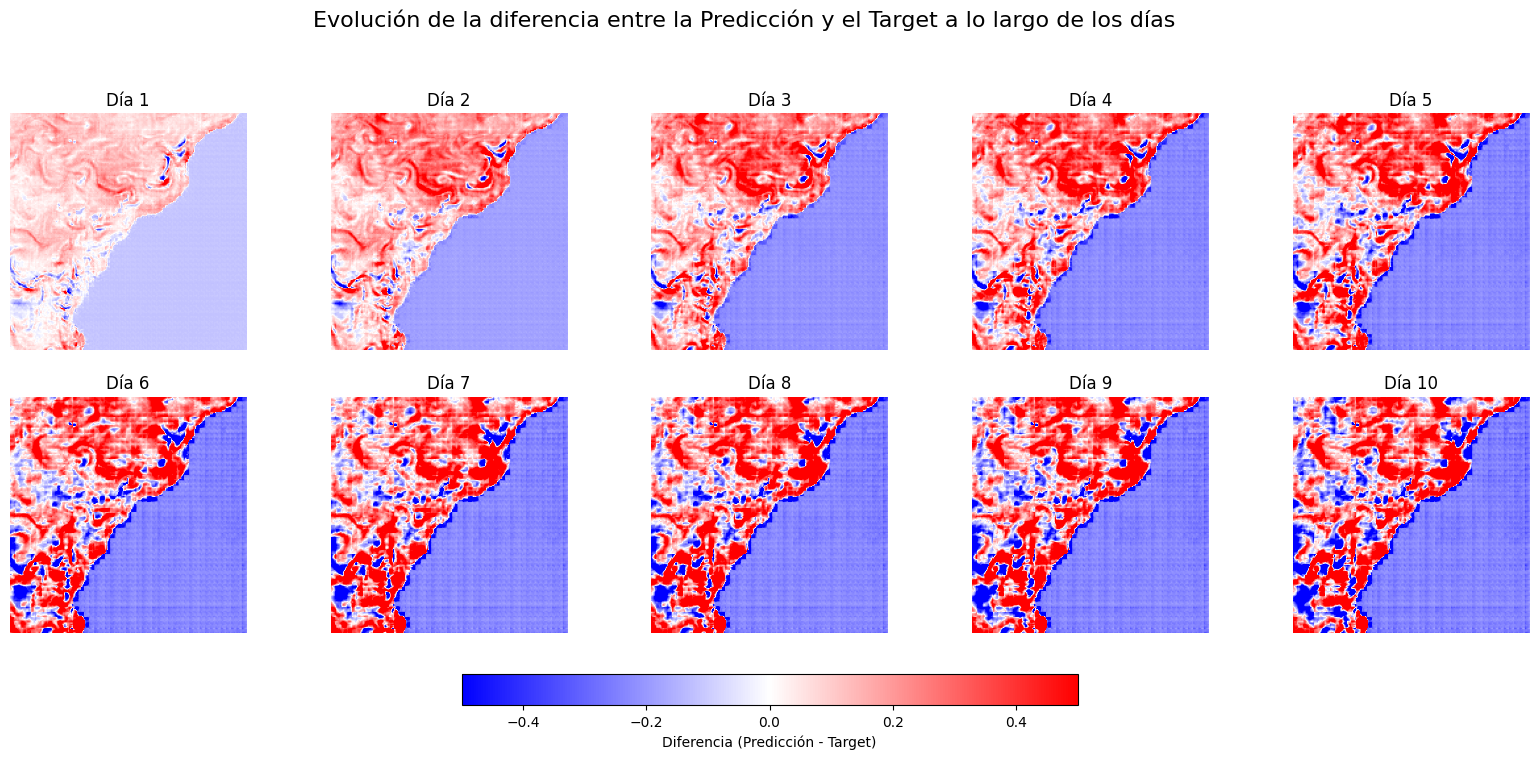

In [18]:
import matplotlib.pyplot as plt

# Elegir un índice de muestra a visualizar (por ejemplo, la primera muestra del test)
sample_idx = 0

# Extraer las dimensiones espaciales (lat, lon)
N_samples = targets_for_comparison.shape[0]
num_days = targets_for_comparison.shape[1]  # Debería ser 10

if sample_idx >= N_samples:
    raise ValueError(f"El índice de muestra {sample_idx} excede el número de muestras en el test ({N_samples}).")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(num_days):
    ax = axes[i]
    predicted_map = predictions_per_day[i][sample_idx, :, :]
    target_map = targets_for_comparison[sample_idx, i, :, :]
    diff_map = predicted_map - target_map

    # Cambiar origin a 'upper' si tus datos vienen ordenados de mayor a menor lat
    im = ax.imshow(diff_map, origin='upper', cmap='bwr', vmin=-0.5, vmax=0.5)
    ax.set_title(f"Día {i+1}")
    ax.axis('off')

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('Diferencia (Predicción - Target)')

# Ajustar el espacio para que la colorbar no se superponga
plt.subplots_adjust(top=0.85, bottom=0.20)
plt.suptitle("Evolución de la diferencia entre la Predicción y el Target a lo largo de los días", fontsize=16)
plt.show()



## RMSE vs Días predichos teniendo en cuenta las estaciones

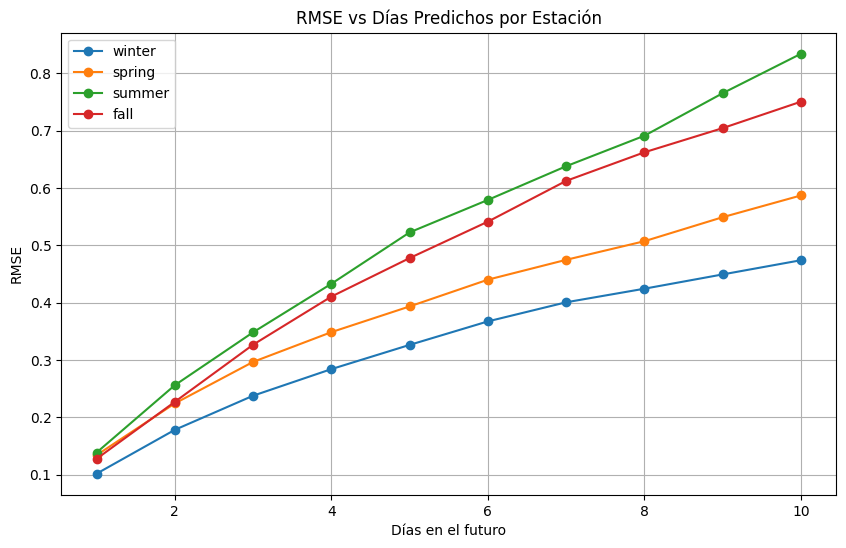

RMSE por día en winter:
Día 1: RMSE = 0.10160533338785172
Día 2: RMSE = 0.17815613746643066
Día 3: RMSE = 0.2376839816570282
Día 4: RMSE = 0.2841121554374695
Día 5: RMSE = 0.32638344168663025
Día 6: RMSE = 0.36740216612815857
Día 7: RMSE = 0.40072333812713623
Día 8: RMSE = 0.42443594336509705
Día 9: RMSE = 0.4493641257286072
Día 10: RMSE = 0.4741284251213074
RMSE por día en spring:
Día 1: RMSE = 0.13391050696372986
Día 2: RMSE = 0.22423020005226135
Día 3: RMSE = 0.29669418931007385
Día 4: RMSE = 0.3486062288284302
Día 5: RMSE = 0.3935041129589081
Día 6: RMSE = 0.4401891827583313
Día 7: RMSE = 0.47481444478034973
Día 8: RMSE = 0.5073192715644836
Día 9: RMSE = 0.5492273569107056
Día 10: RMSE = 0.5871627926826477
RMSE por día en summer:
Día 1: RMSE = 0.13840018212795258
Día 2: RMSE = 0.256007581949234
Día 3: RMSE = 0.34833216667175293
Día 4: RMSE = 0.4329985976219177
Día 5: RMSE = 0.5226861834526062
Día 6: RMSE = 0.5793437957763672
Día 7: RMSE = 0.6381378769874573
Día 8: RMSE = 0.69138252

In [ ]:
import random

def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

# Asumiendo que ya tienes: 
# predictions_per_day: lista de length 10, cada ítem es array (N_samples, lat, lon)
# targets_for_comparison: array (N_samples, 10, lat, lon)
# timestamps: lista de length N_samples, cada uno es un datetime

# 1. Obtener la estación para cada muestra
sample_seasons = []
for t in timestamps:
    month = t.month
    season = get_season(month)
    sample_seasons.append(season)

sample_seasons = np.array(sample_seasons)  # Ahora es un array con las estaciones de cada muestra

# 2. Para cada estación, seleccionaremos 10 muestras aleatorias
all_seasons = ['winter', 'spring', 'summer', 'fall']
num_samples_per_season = 10

rmse_per_day_by_season = {}

for season_name in all_seasons:
    # Filtrar las muestras de esta estación
    season_indices = np.where(sample_seasons == season_name)[0]

    if len(season_indices) < num_samples_per_season:
        raise ValueError(f"No hay suficientes muestras en la estación {season_name} para seleccionar {num_samples_per_season}.")

    # Seleccionar 10 muestras aleatorias de esta estación
    selected_indices = np.random.choice(season_indices, size=num_samples_per_season, replace=False)

    # Extraer predicciones y targets correspondientes a estas muestras
    # predictions_per_day[i]: (N_samples, lat, lon)
    # targets_for_comparison: (N_samples, 10, lat, lon)
    # Para las 10 muestras seleccionadas:
    season_preds = [predictions_per_day[i][selected_indices, :, :] for i in range(10)]
    # Convertimos a un array de shape (10, num_samples_per_season, lat, lon)
    season_preds = np.stack(season_preds, axis=0)

    season_targets = targets_for_comparison[selected_indices, :, :, :]  # (num_samples_per_season, 10, lat, lon)
    # Queremos (10, num_samples_per_season, lat, lon) para facilitar el cálculo
    season_targets = np.transpose(season_targets, (1, 0, 2, 3))  # (10, num_samples, lat, lon)

    # Calcular RMSE medio por día para estas 10 muestras y esta estación
    season_rmse = []
    for day_idx in range(10):
        day_preds = season_preds[day_idx]   # (num_samples, lat, lon)
        day_targets = season_targets[day_idx]  # (num_samples, lat, lon)
        rmse_day = metricas.rmse(day_preds, day_targets)
        season_rmse.append(rmse_day)

    rmse_per_day_by_season[season_name] = season_rmse

# 3. Graficar RMSE vs Días para cada estación
days = np.arange(1, 11)
plt.figure(figsize=(10, 6))
for season_name in all_seasons:
    plt.plot(days, rmse_per_day_by_season[season_name], marker='o', label=season_name)

plt.title('RMSE vs Días Predichos por Estación')
plt.xlabel('Días en el futuro')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

# Imprimir los valores
for season_name in all_seasons:
    print(f"RMSE por día en {season_name}:")
    for d, rmse_val in zip(days, rmse_per_day_by_season[season_name]):
        print(f"Día {d}: RMSE = {rmse_val}")


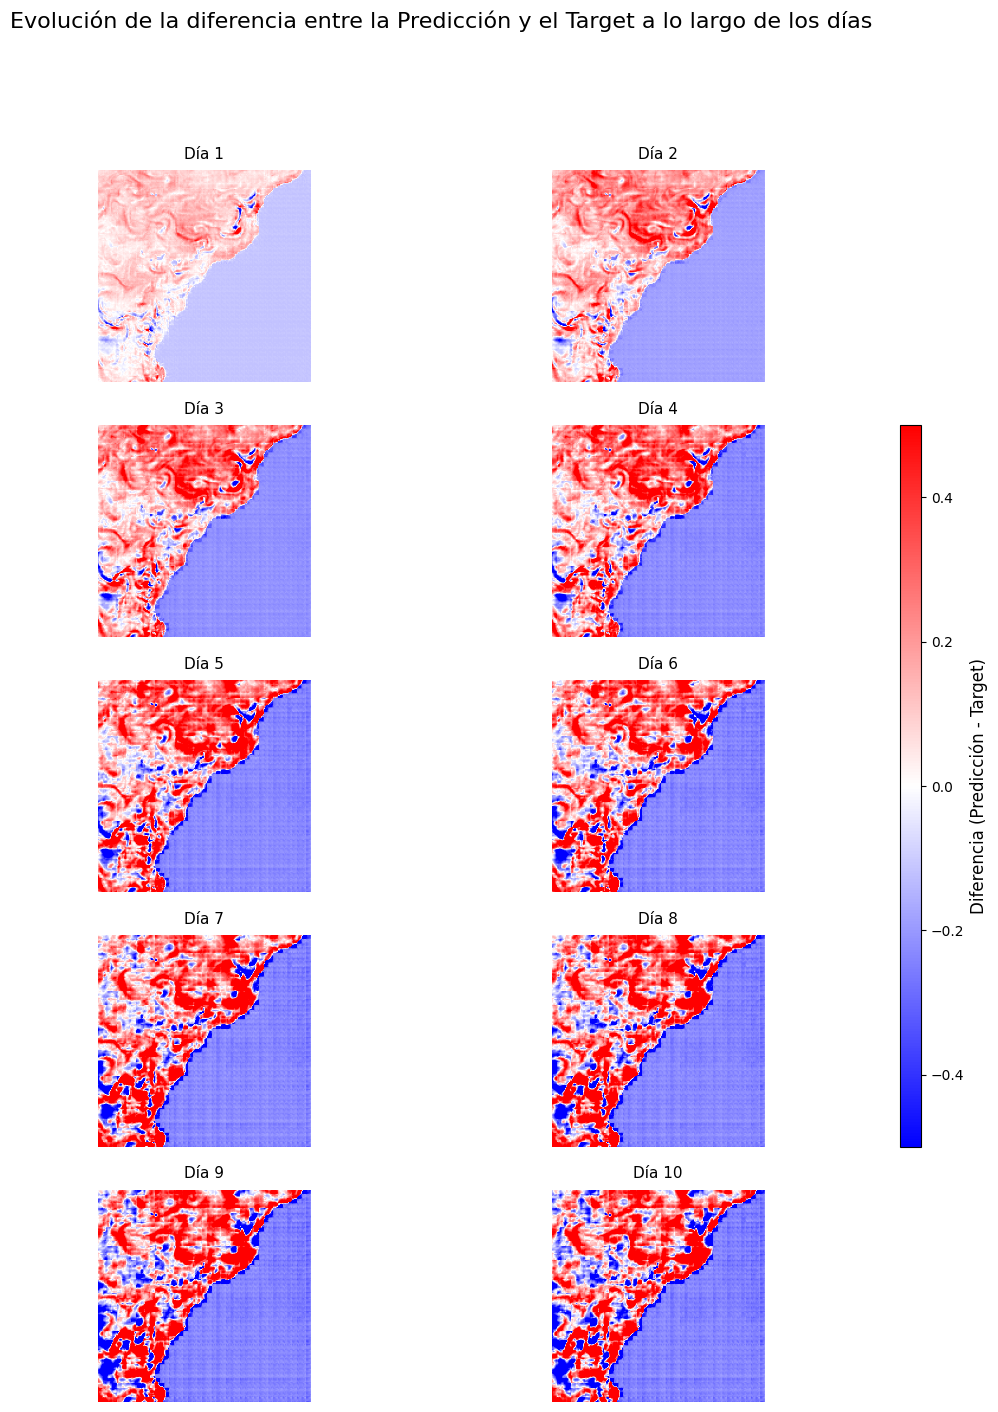

In [47]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Elegir un índice de muestra a visualizar (por ejemplo, la primera muestra del test)
sample_idx = 0

# Extraer las dimensiones espaciales (lat, lon)
N_samples = targets_for_comparison.shape[0]
num_days = targets_for_comparison.shape[1]  # Debería ser 10

if sample_idx >= N_samples:
    raise ValueError(f"El índice de muestra {sample_idx} excede el número de muestras en el test ({N_samples}).")

# Crear una figura ajustada
fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(5, 3, width_ratios=[1, 1, 0.05], wspace=0.1, hspace=0.2)

axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(num_days)]
cbar_ax = fig.add_subplot(gs[1:4, 2])  # Barra de color más corta, ocupando filas 1 a 4

for i in range(num_days):
    ax = axes[i]
    predicted_map = predictions_per_day[i][sample_idx, :, :]
    target_map = targets_for_comparison[sample_idx, i, :, :]
    diff_map = predicted_map - target_map

    # Cambiar origin a 'upper' si tus datos vienen ordenados de mayor a menor lat
    im = ax.imshow(diff_map, origin='upper', cmap='bwr', vmin=-0.5, vmax=0.5)
    ax.set_title(f"Día {i+1}", fontsize=11, pad=8)
    ax.axis('off')

# Crear barra de color más compacta
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.5)
cbar.set_label('Diferencia (Predicción - Target)', fontsize=12)

# Ajustar el título principal
plt.suptitle("Evolución de la diferencia entre la Predicción y el Target a lo largo de los días",
             fontsize=16, y=0.98)

plt.show()


# **Resultados y Visualizaciones**

## 1. RMSE vs. Días Predichos

En la siguiente tabla se muestran los RMSE promedio (ponderado por latitud) para cada horizonte de 1 a 10 días:

- **Día 1**: \~0.125  
- **Día 2**: \~0.216  
- **Día 3**: \~0.289  
- **Día 4**: \~0.352  
- **Día 5**: \~0.410  
- **Día 6**: \~0.464  
- **Día 7**: \~0.514  
- **Día 8**: \~0.562  
- **Día 9**: \~0.607  
- **Día 10**: \~0.650  

Como se aprecia, el error medio cuadrático **aumenta progresivamente** con el horizonte de pronóstico, lo cual es esperado en muchos sistemas de predicción donde la **incertidumbre** se propaga con el paso de los días.

## 2. Evolución Espacial de la Diferencia

Se visualiza, para una muestra concreta, la **diferencia** (Predicción - Target) en mapas 2D durante los 10 días. Típicamente:

- Al **Día 1**, la diferencia es relativamente baja.
- Hacia días avanzados (p. ej., **Día 7-10**), la disparidad se hace mayor (especialmente en áreas con fuerte gradiente).

Esta discrepancia espacial puede ser explorada para ver **dónde** la red necesita mayor ajuste o dónde la variabilidad oceánica es más difícil de capturar.

# **Conclusión**

La predicción a largo plazo **rollout(steps=10)** muestra cómo el **error crece** gradualmente con cada día adicional de pronóstico:

- **Día 1** con ~0.125 de RMSE.  
- **Día 10** llegando a ~0.65 de RMSE.  

Visualmente, se comprueba que la **diferenica espacial** también aumenta a medida que nos alejamos en el horizonte de predicción. No obstante, estos resultados siguen siendo razonables y útiles para evaluar la capacidad del modelo Aurora en pronósticos de mayor alcance temporal.  

En suma, la metodología de *rollout* multi-día ofrece una visión clara de la **degradación** de la calidad de predicción con el paso de los días y abre la puerta a mejoras adicionales, como *ensembles*, *reentrenos periódicos*, o *técnicas de corrección de error acumulado*.  